In [1]:
import pandas as pd
import scanpy as sc
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import anndata

In [3]:
df = pd.read_table("data/csv/sc_10x_5cl.count.csv.gz", compression="gzip", sep=",")

# A) Single Cell analysis

### 1) preparazione: filtro via tutti le cellule con molti geni mitocondriali (cellule morenti) e i geni del ciclo cellulare (variabilità all'interno della stessa linea)

In [4]:
adata = anndata.AnnData(df.T)#.values.T, obs=df.columns, var=df.index)
cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]

In [5]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

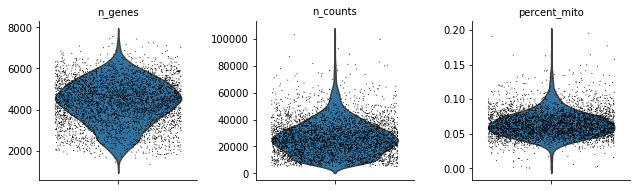

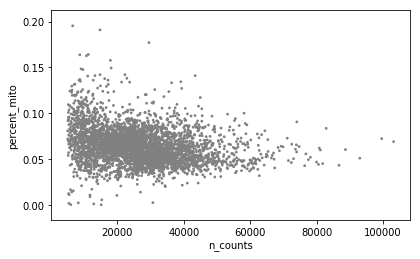

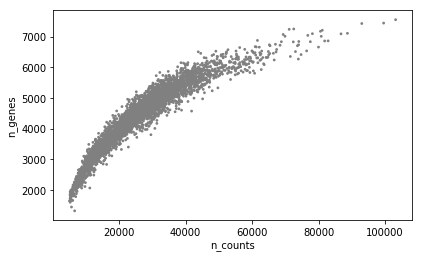

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)


np.sum(adata[:, mito_genes].X, axis=1)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)


sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



adata = adata[adata.obs['percent_mito'] < 0.05, :]


In [7]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


In [8]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


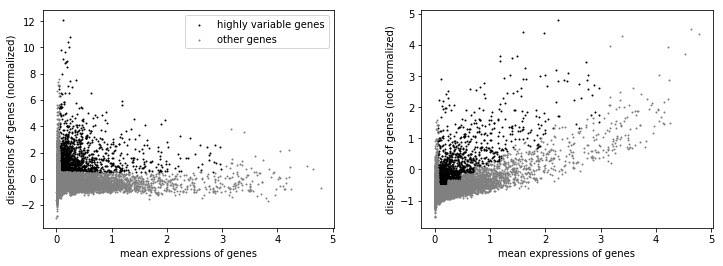

In [9]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [10]:
adata = adata[:, adata.var['highly_variable']]

In [11]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score','n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) #i geni con una varianza più alta di 10 gli viene attribuita varianza uguale a 10

Trying to set attribute `.obs` of view, making a copy.
... storing 'phase' as categorical


### 2) PCA e grafico UMAP

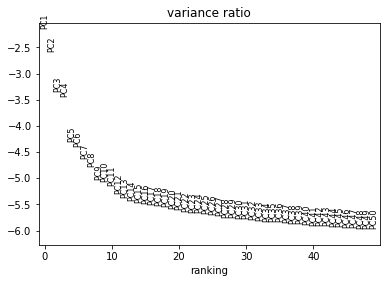

In [12]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [13]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [14]:
sc.tl.umap(adata) 

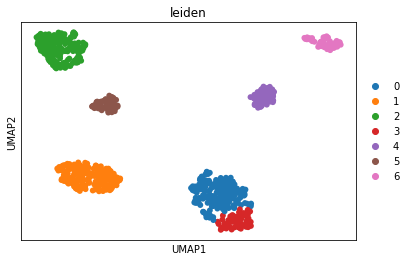

In [15]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color="leiden")

### 3) nomi ai cluster

In [16]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

In [17]:
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo

In [18]:
df_significativo.head()

,0,1,2,3,4,5,6
0,CD74,SEC61G,GAGE12D,XAGE1B,MT1E,AKR1B10,RPS28P7
1,LCN2,RPL7P9,GAGE12E,MMP7,LGALS1,KRT81,RPS15
2,SAA1,CDKN2A,GAGE12G,TMSB4X,DHRS2,AKR1C2,XAGE1B
3,CXCL1,RPL7,GAGE2E,RAC1,PEG10,ALDH1A1,AC007969.1
4,HLA-B,CHCHD2,GAGE2A,TPT1,RPS5,AKR1C3,LGALS1


In [19]:
cell_annotation= pd.read_table('data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)

In [20]:
cell_annotation.head()

,unaligned,aligned_unmapped,mapped_to_exon,mapped_to_intron,ambiguous_mapping,mapped_to_ERCC,mapped_to_MT,number_of_genes,total_count_per_cell,non_mt_percent,...,pct_counts_in_top_500_features,total_features,log10_total_features,pct_counts_top_50_features,pct_counts_top_100_features,pct_counts_top_200_features,pct_counts_top_500_features,cell_line,cell_line_demuxlet,demuxlet_cls
Lib90_00000,22485,2861,129248,10666,5503,0,9095,8344,104055,0.801874,...,67.118351,8344,3.921426,27.307674,39.538705,52.677911,67.118351,HCC827,HCC827,SNG
Lib90_00001,20325,2383,124178,11106,5308,0,9170,8216,100421,0.802860,...,68.047520,8216,3.914713,27.729260,40.342160,53.850290,68.047520,HCC827,HCC827,DBL
Lib90_00002,19279,2732,116260,9561,5064,0,6044,8121,93744,0.799806,...,61.432198,8121,3.909663,21.509643,32.380739,45.084485,61.432198,H838,H838,SNG
Lib90_00003,18580,2575,109675,11012,4764,0,6806,7809,89426,0.814897,...,71.056516,7809,3.892651,29.270011,43.419140,57.277526,71.056516,HCC827,HCC827,SNG
Lib90_00004,17759,2067,108807,9501,4809,0,4794,7807,87517,0.813591,...,67.645143,7807,3.892540,26.262326,39.047271,52.941714,67.645143,HCC827,HCC827,SNG


In [21]:
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line'],
      dtype='object')

In [22]:
adata.obs.loc[:, "cell_line_demuxlet"] = cell_annotation.loc[adata.obs_names, "cell_line_demuxlet"]
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line', 'cell_line_demuxlet'],
      dtype='object')

... storing 'cell_line' as categorical
... storing 'cell_line_demuxlet' as categorical


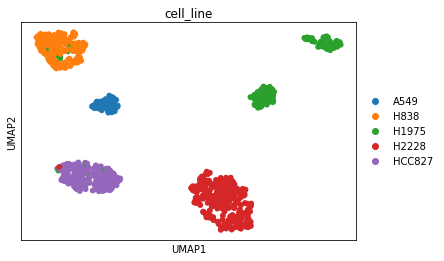

In [23]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line")

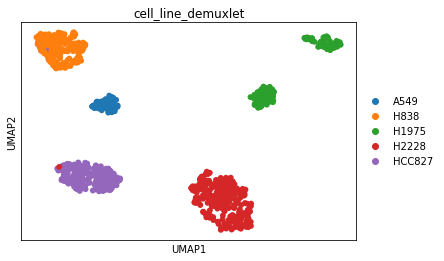

In [24]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line_demuxlet")

In [31]:
adata.write('adata_10x/adata_sc_10x.h5ad')

# B) PAGA

### 1) PAGA senza informazioni preliminari

In [32]:
sc.tl.diffmap(adata)

sc.pp.neighbors(adata, n_neighbors=10)

In [33]:
sc.tl.leiden(adata, resolution=0.2)

In [34]:
sc.tl.paga(adata, groups='leiden')

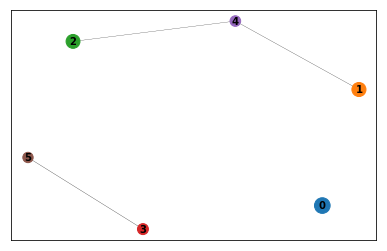

In [35]:
sc.pl.paga(adata, color=['leiden'])

In [36]:
adata.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5'], dtype='object')

In [37]:
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line', 'cell_line_demuxlet'],
      dtype='object')

### 2) Istruisco PAGA con il nome delle cell line

In [38]:
adata.obs['cell_line'].cat.categories

Index(['A549', 'H838', 'H1975', 'H2228', 'HCC827'], dtype='object')

In [39]:
sc.tl.paga(adata, groups='cell_line')

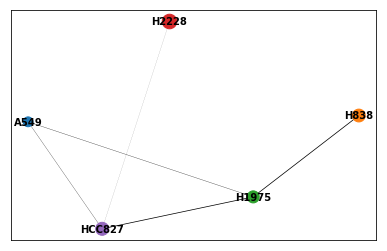

In [40]:
sc.pl.paga(adata, random_state=3124)

In [41]:
sc.tl.paga(adata, groups='cell_line_demuxlet')

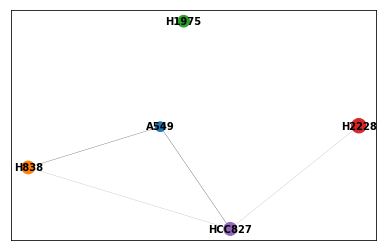

In [42]:
sc.pl.paga(adata, random_state=8)

### 3) inizializzo la computazione con PAGA

In [43]:
sc.tl.draw_graph(adata, init_pos='paga')

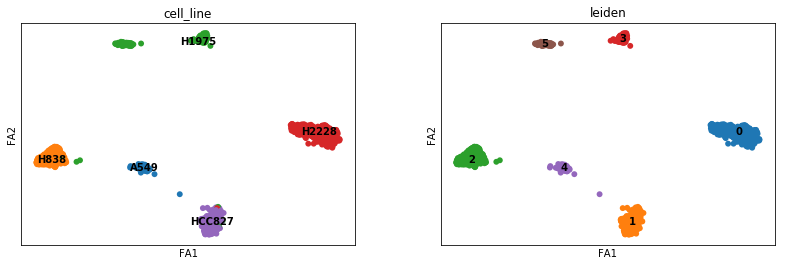

In [44]:
sc.pl.draw_graph(adata, color=['cell_line', 'leiden'], legend_loc='on data')

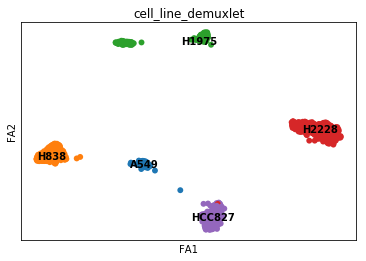

In [45]:
sc.pl.draw_graph(adata, color=['cell_line_demuxlet'], legend_loc='on data')

In [46]:
adata


AnnData object with n_obs × n_vars = 860 × 1596 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'cell_line', 'cell_line_demuxlet'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'cell_line_colors', 'cell_line_demuxlet_colors', 'diffmap_evals', 'paga', 'leiden_sizes', 'cell_line_sizes', 'cell_line_demuxlet_sizes', 'draw_graph'
    obsm: 'X_pca', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'

In [48]:
adata.write('adata_10x/adata_sc_paga_10x.h5ad')